In [167]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns                               
import json
import os 
from sklearn.preprocessing import StandardScaler

In [168]:
# 資料前處理 (一): 刪除每個 Label 的前後 n 筆資料
def remove_first_last_n(data, label_column, n=20):
    data = data.sort_values(by=label_column).reset_index(drop=True)
    processed_data = pd.DataFrame(columns=data.columns)
    for label, group in data.groupby(label_column):
        if len(group) > 2 * n:
            group = group.iloc[n:-n]
        else:
            group = pd.DataFrame()  # 若資料不足，刪除整個群組
        processed_data = pd.concat([processed_data, group], ignore_index=True)
    return processed_data

def fill_nan_with_mean(processed_data,label_column):
    data_imputed = processed_data.groupby(label_column).apply(
        lambda group: group.fillna(group.mean())
    ).reset_index()
    return data_imputed

# 資料前處理 (二): 用 KNNImputer 填補缺失值
def KNN_inputer_fill_nan(processed_data, n=5):
    # 確定數值型與類別型欄位
    numeric_columns = processed_data.select_dtypes(include=['float', 'int']).columns
    non_numeric_columns = processed_data.select_dtypes(exclude=['float', 'int']).columns

    # 取出數值型資料
    numeric_data = processed_data[numeric_columns]

    # 使用 KNNImputer 填補數值型缺失值
    imputer = KNNImputer(n_neighbors=n)
    numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_columns)

    # 填補類別型資料的缺失值（使用 mode）
    categorical_data = processed_data[non_numeric_columns].copy()
    for col in categorical_data.columns:
        if categorical_data[col].isnull().any():
            categorical_data[col].fillna(categorical_data[col].mode()[0], inplace=True)
    # 合併數值型與類別型資料
    data_imputed = pd.concat([numeric_data_imputed, categorical_data.reset_index(drop=True)], axis=1)
    return data_imputed

def plot_class_distribution(data, label_column, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=label_column, data=data, order=data[label_column].value_counts().index)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# 訓練 KNN 模型
def train_knn_model(X_train, y_train, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    return knn

In [169]:
traindate = '2024_12_14'
testdate = '2025_01_10'

with_data = 'distance'

In [170]:
train_path = f'timestamp_allignment_Balanced_{traindate}_rtt_logs.csv'
test_path = f'timestamp_allignment_Balanced_{testdate}_rtt_logs.csv'

# train_path = f'standalized_timestamp_allignment_{traindate}_rtt_logs.csv'
# test_path = f'standalized_timestamp_allignment_{testdate}_rtt_logs.csv'

In [171]:
# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']
# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)'] 

# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi'] 
# 
# selected_columns = ['Label', 'AP1_Corrected Distance (mm)','AP2_Corrected Distance (mm)','AP3_Corrected Distance (mm)','AP4_Corrected Distance (mm)'] 

# selected_columns = ['Label', 'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi',
#                     'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)'] 

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)',
#                     'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)',
#                     'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)']   

# selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)',
#                     'AP1_StdDev (mm)','AP2_StdDev (mm)','AP3_StdDev (mm)','AP4_StdDev (mm)',
#                     'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']  

# selected_columns = ['Label', 'AP1_Corrected Distance (mm)','AP2_Corrected Distance (mm)','AP3_Corrected Distance (mm)','AP4_Corrected Distance (mm)',
#                      'AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi']

In [172]:
# 讀取資料
train_data = pd.read_csv(train_path, usecols=selected_columns)
test_data = pd.read_csv(test_path, usecols=selected_columns)

In [173]:
n_remove = 20
n_neighbors = 5

C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)
C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


   AP1_Distance (mm)  AP2_Distance (mm)  AP3_Distance (mm)  AP4_Distance (mm)
0             4233.0             6811.0            11650.0             -889.0
1             3838.0             6928.0            11611.0             -889.0
2             4155.0             6460.0            11924.0             -694.0
3             3960.0             6753.0            12041.0             -811.0
4             3960.0             6635.0            11650.0             -928.0


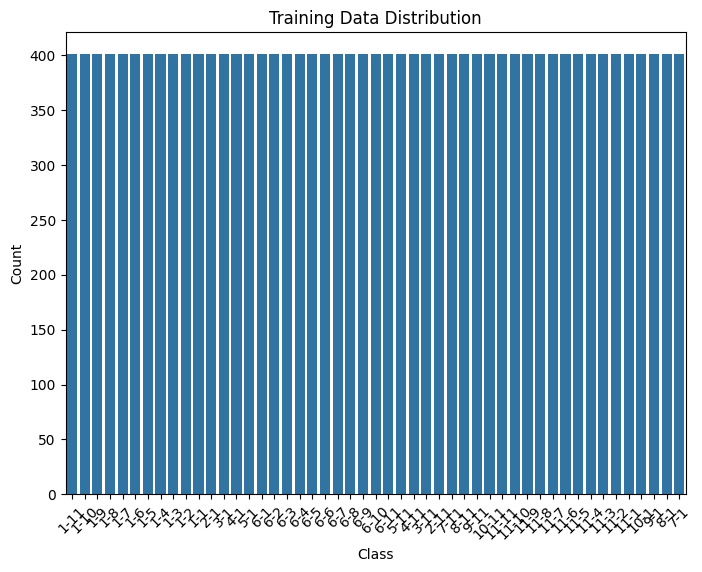

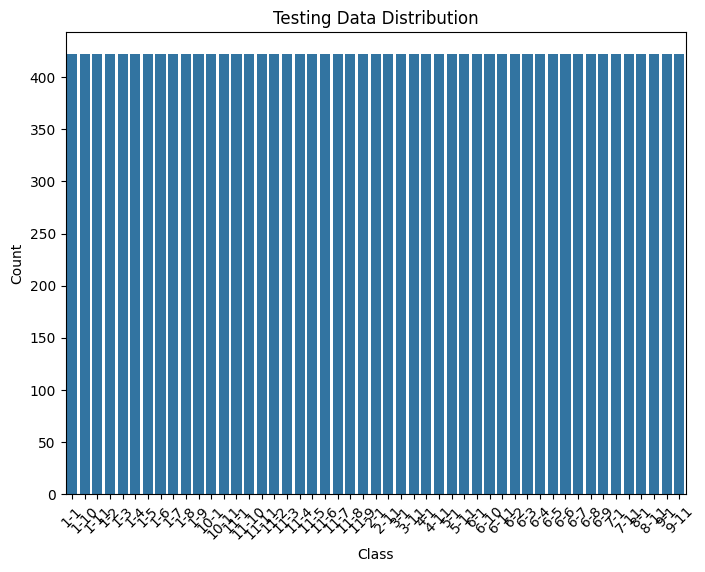

In [174]:
# 資料清理
train_data_p = remove_first_last_n(train_data, label_column=['Label'], n=n_remove)
test_data_p = remove_first_last_n(test_data, label_column=['Label'], n=n_remove)


train_data_p = fill_nan_with_mean(train_data_p,label_column=['Label'])
test_data_p = fill_nan_with_mean(test_data_p,label_column=['Label'])


# print(train_data_p)

# 分離特徵與標籤
X_train = train_data_p.drop(columns=['level_1','Label'])
y_train = train_data_p['Label']
X_test = test_data_p.drop(columns=['level_1','Label'])
y_test = test_data_p['Label']

print(X_train.head())



# 訓練資料分佈
plot_class_distribution(train_data, label_column='Label', title="Training Data Distribution")

# 測試資料分佈
plot_class_distribution(test_data, label_column='Label', title="Testing Data Distribution")



In [175]:
# X_train['AP1_Distance (mm)'] = X_train['AP1_Distance (mm)'] / 100
# X_test['AP1_Distance (mm)'] = X_test['AP1_Distance (mm)'] / 100

# print(X_train.head())
# print(X_test.head())

In [176]:
# 使用 Z-score 標準化
scaler = StandardScaler() 
selected_columns.remove('Label')

scaler.fit(X_train[selected_columns])

# 標準化數據
X_train.loc[:, selected_columns] = scaler.transform(X_train[selected_columns])
X_test.loc[:, selected_columns] = scaler.transform(X_test[selected_columns])

print(X_train.head())
print(X_test.head())


   AP1_Distance (mm)  AP2_Distance (mm)  AP3_Distance (mm)  AP4_Distance (mm)
0           0.615778           0.540147           1.822815          -1.476931
1           0.449047           0.580152           1.808008          -1.476931
2           0.582854           0.420132           1.926839          -1.396360
3           0.500544           0.520315           1.971258          -1.444702
4           0.500544           0.479969           1.822815          -1.493045
   AP1_Distance (mm)  AP2_Distance (mm)  AP3_Distance (mm)  AP4_Distance (mm)
0           0.517006           0.727178           2.542251          -1.283560
1           0.467620           0.630414           2.486442          -1.315789
2           0.533468           0.767183           2.712714          -1.267033
3           0.434696           0.730597           2.764726          -1.299675
4           0.549930           0.710424           2.731316          -1.267033


In [177]:
# 將 ditance 權重設為2被

# X_train['AP1_Distance (mm)'] = X_train['AP1_Distance (mm)'] * 2
# X_test['AP1_Distance (mm)'] = X_test['AP1_Distance (mm)'] * 2

# print(X_train.head())
# print(X_test.head())

In [178]:
label_to_coordinates = {
    "1-1": (0, 0), "1-2": (0.6, 0), "1-3": (1.2, 0), "1-4": (1.8, 0), "1-5": (2.4, 0), "1-6": (3.0, 0),"1-7": (3.6, 0), "1-8": (4.2, 0), "1-9": (4.8, 0), "1-10": (5.4, 0), "1-11": (6.0, 0),
    "2-1": (0, 0.6), "2-11": (6.0, 0.6),
    "3-1": (0, 1.2), "3-11": (6.0, 1.2),
    "4-1": (0, 1.8), "4-11": (6.0, 1.8),
    "5-1": (0, 2.4), "5-11": (6.0, 2.4),
    "6-1": (0, 3.0), "6-2": (0.6, 3.0), "6-3": (1.2, 3.0), "6-4": (1.8, 3.0), "6-5": (2.4, 3.0),"6-6": (3.0, 3.0), "6-7": (3.6, 3.0), "6-8": (4.2, 3.0), "6-9": (4.8, 3.0), "6-10": (5.4, 3.0), "6-11": (6.0, 3.0),
    "7-1": (0, 3.6), "7-11": (6.0, 3.6),
    "8-1": (0, 4.2), "8-11": (6.0, 4.2),
    "9-1": (0, 4.8), "9-11": (6.0, 4.8),
    "10-1": (0, 5.4), "10-11": (6.0, 5.4),
    "11-1": (0, 6.0), "11-2": (0.6, 6.0), "11-3": (1.2, 6.0), "11-4": (1.8, 6.0), "11-5": (2.4, 6.0),"11-6": (3.0, 6.0), "11-7": (3.6, 6.0), "11-8": (4.2, 6.0), "11-9": (4.8, 6.0), "11-10": (5.4, 6.0), "11-11": (6.0, 6.0)
}

In [179]:
# 訓練模型
knn = train_knn_model(X_train, y_train, n_neighbors=n_neighbors)

In [180]:
# 評估模型
report_save_path = f'transfer_report_{traindate}_data_to_train_{testdate}_data_to_test_{with_data}.txt'
y_pred = knn.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
# MDE
# Calculate MDE metrics
y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_pred])
y_test_coordinates = np.array([label_to_coordinates[label] for label in y_test])

# 計算各點的距離
distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
mean_distance_error = np.mean(distances)


# 計算每個點的 MDE
pointwise_mde = {}
for label in np.unique(y_test):
    # 過濾對應於該標籤的測試點
    indices = np.where(y_test == label)
    if len(indices[0]) > 0:
        point_distances = distances[indices]
        pointwise_mde[label] = {
            "count": len(point_distances),
            "MDE": np.mean(point_distances)
        }
    else:
        pointwise_mde[label] = {
            "count": 0,
            "MDE": None
        }



In [181]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean Distance Error (MDE): {mean_distance_error:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in np.unique(y_test)]))

# 生成 classification report 並保存
report = classification_report(y_test, y_pred, output_dict=True)
# 將 MDE 加入 report
report["Mean Distance Error (MDE)"] = mean_distance_error
report["accuracy"] = accuracy  # 加入準確度
report["Pointwise MDE"] = pointwise_mde  # 加入每個點的 MDE


if not os.path.exists(report_save_path):
    with open(report_save_path, 'w') as f:
        f.write("")  # Create an empty file

with open(report_save_path, "w") as f:
    json.dump(report, f, indent=4)

print(f"Updated report with MDE saved to: {report_save_path}")

Test Accuracy: 0.4747
Mean Distance Error (MDE): 0.4812
Classification Report:
              precision    recall  f1-score   support

         1-1       0.99      0.27      0.42       382
        1-10       0.77      0.32      0.45       382
        1-11       0.54      1.00      0.70       382
         1-2       0.67      0.98      0.80       382
         1-3       0.26      0.25      0.25       382
         1-4       0.53      0.93      0.67       382
         1-5       0.15      0.17      0.16       382
         1-6       0.60      0.01      0.02       382
         1-7       0.90      0.54      0.68       382
         1-8       0.66      0.98      0.79       382
         1-9       0.90      0.15      0.25       382
        10-1       0.78      0.91      0.84       382
       10-11       0.70      0.70      0.70       382
        11-1       0.54      0.96      0.69       382
       11-10       0.22      0.26      0.24       382
       11-11       0.06      0.03      0.04       382
  

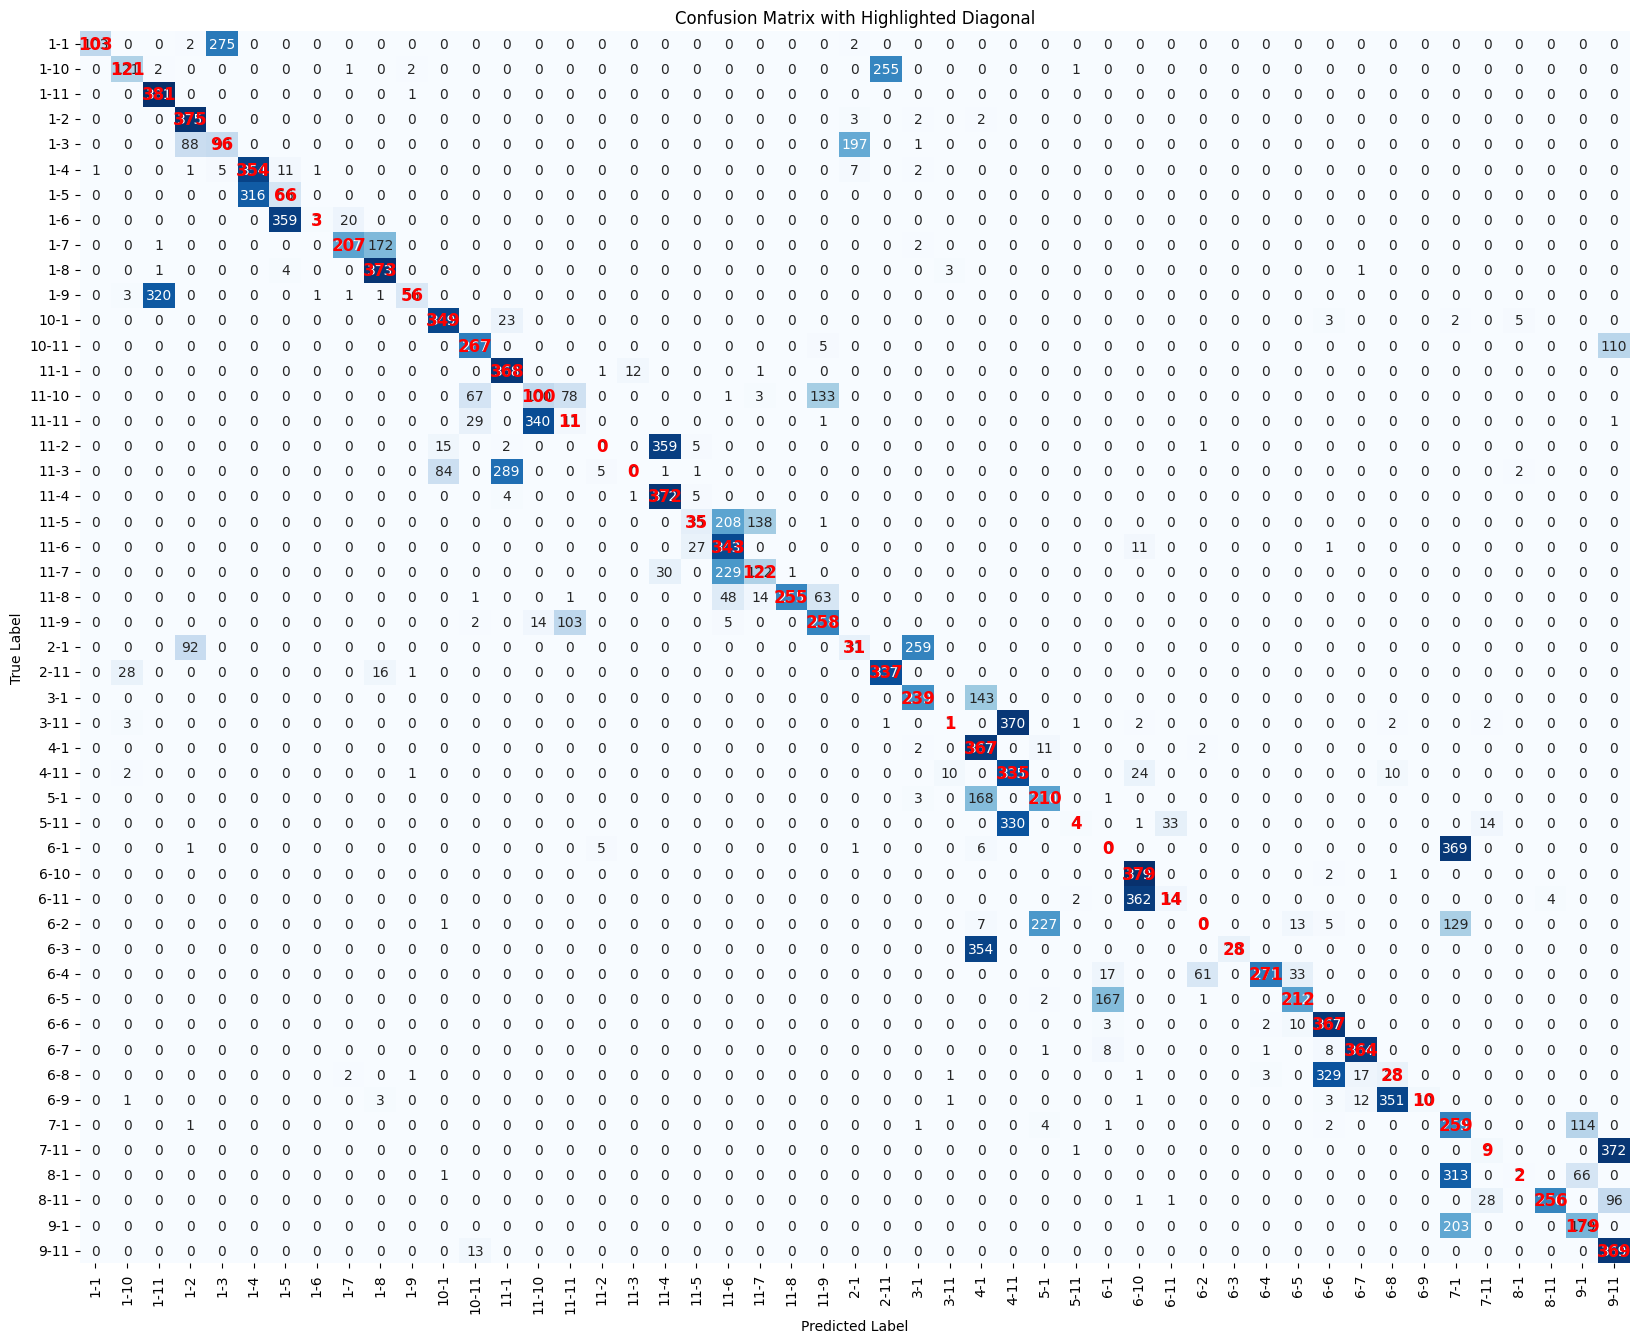

In [182]:
# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred)
num_classes = cm.shape[0]

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            cbar=False)

# 手動修改對角線文字顏色為紅色
for i in range(num_classes):
    plt.text(i + 0.5, i + 0.5, cm[i, i], 
                color="red", ha="center", va="center", fontsize=12, fontweight="bold")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Highlighted Diagonal")
plt.show()

{'1-1': {'precision': 0.9903846153846154, 'recall': 0.2696335078534031, 'f1-score': 0.42386831275720166, 'support': 382.0}, '1-10': {'precision': 0.7658227848101266, 'recall': 0.31675392670157065, 'f1-score': 0.44814814814814813, 'support': 382.0}, '1-11': {'precision': 0.5404255319148936, 'recall': 0.9973821989528796, 'f1-score': 0.7010119595216191, 'support': 382.0}, '1-2': {'precision': 0.6696428571428571, 'recall': 0.981675392670157, 'f1-score': 0.7961783439490446, 'support': 382.0}, '1-3': {'precision': 0.2553191489361702, 'recall': 0.2513089005235602, 'f1-score': 0.2532981530343008, 'support': 382.0}, '1-4': {'precision': 0.5283582089552239, 'recall': 0.9267015706806283, 'f1-score': 0.6730038022813688, 'support': 382.0}, '1-5': {'precision': 0.15, 'recall': 0.17277486910994763, 'f1-score': 0.16058394160583941, 'support': 382.0}, '1-6': {'precision': 0.6, 'recall': 0.007853403141361256, 'f1-score': 0.015503875968992248, 'support': 382.0}, '1-7': {'precision': 0.8961038961038961, '

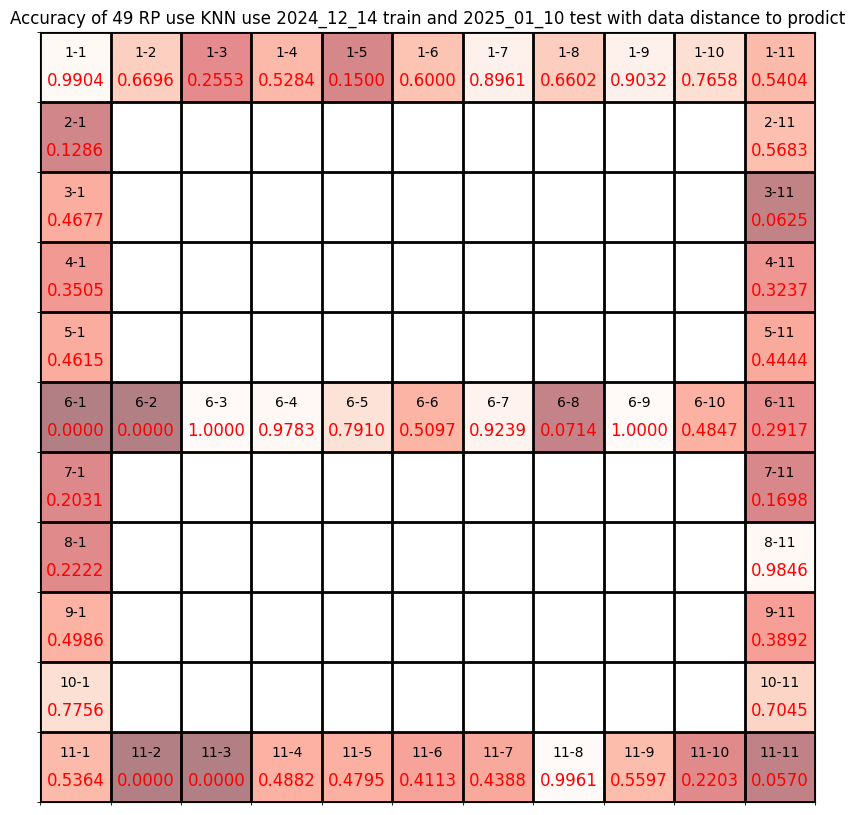

In [183]:
Title = f"Accuracy of 49 RP use KNN use {traindate} train and {testdate} test with data {with_data} to prodict"
file_path = f'transfer_report_{traindate}_data_to_train_{testdate}_data_to_test_{with_data}.txt'

# Load the figure.txt JSON file
with open(file_path) as file:
    data = json.load(file)

print(data)

# Filter out keys that are not class labels (e.g., "accuracy", "macro avg")
filtered_data = {k: v for k, v in data.items() if '-' in k}

print(filtered_data)

# Extract precision values without mapping
precision_values = {k: v['precision'] for k, v in filtered_data.items()}

precision_values

# Grid layout (11x11)
rows, cols = 11, 11
grid = np.full((rows, cols), np.nan)  # Initialize grid with NaN
labels = np.empty((rows, cols), dtype=object)  # Initialize grid for labels

# Populate the grid with precision values and labels (reverse row index for correct plotting)
for key, value in precision_values.items():
    if '-' in key:
        r, c = map(int, key.split('-'))
        grid[rows - r, c - 1] = value  # Reverse rows for top-left (1-1) to bottom-left (11-1)
        labels[rows - r, c - 1] = key

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Reds_r  # Color map

# 設定自定義顏色範圍
vmin = 0  # 最小值對應的顏色
vmax = np.nanmax(grid) * 0.5  # 最大值對應的顏色 (縮小範圍讓顏色對比更明顯)

log_grid = np.log(grid + 1e-6)  # 避免取 log(0)

# Draw grid with precision values and labels
for i in range(rows):
    for j in range(cols):
        value = grid[i, j]
        label = labels[i, j]
        if not np.isnan(value):
            ax.text(j, i + 0.2, f'{label}', ha='center', va='center', color='black', fontsize=10)
            ax.text(j, i - 0.2, f'{value:.4f}', ha='center', va='center', color='red', fontsize=12)
        rect_color = cmap(value / np.nanmax(grid)) if not np.isnan(value) else 'white'
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color, alpha=0.5))


# Format grid
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.title(Title)
plt.show()

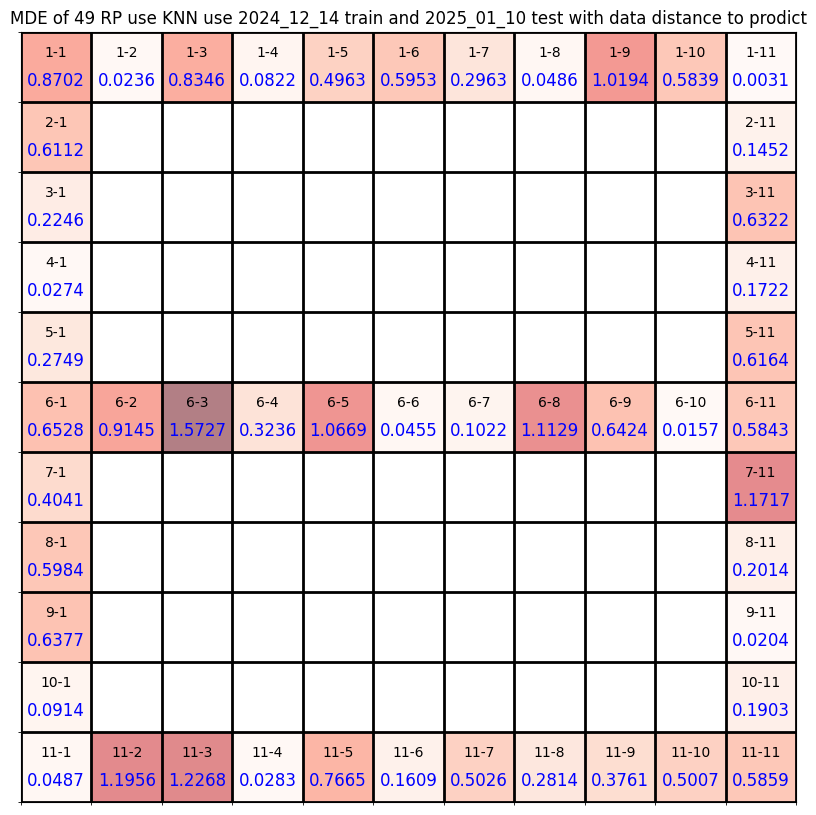

In [184]:
Title = f"MDE of 49 RP use KNN use {traindate} train and {testdate} test with data {with_data} to prodict"
file_path = f'transfer_report_{traindate}_data_to_train_{testdate}_data_to_test_{with_data}.txt'

# 載入 JSON 報告
with open(file_path) as file:
    mde_data = json.load(file)

# 提取 Pointwise MDE
pointwise_mde = mde_data.get("Pointwise MDE", {})

# 將 MDE 填入網格
rows, cols = 11, 11
grid = np.full((rows, cols), np.nan)  # 初始化網格
labels = np.empty((rows, cols), dtype=object)  # 初始化標籤

# 填充網格數據
for key, value in pointwise_mde.items():
    if '-' in key:
        r, c = map(int, key.split('-'))
        grid[rows - r, c - 1] = value["MDE"]  # 反轉行索引以正確對應圖表
        labels[rows - r, c - 1] = key

# 繪製圖表
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Reds  # 顏色映射

# 畫出每個網格
for i in range(rows):
    for j in range(cols):
        value = grid[i, j]
        label = labels[i, j]
        if not np.isnan(value):
            ax.text(j, i + 0.2, f'{label}', ha='center', va='center', color='black', fontsize=10)
            ax.text(j, i - 0.2, f'{value:.4f}', ha='center', va='center', color='blue', fontsize=12)
        rect_color = cmap(value / np.nanmax(grid)) if not np.isnan(value) else 'white'
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color, alpha=0.5))

# 格式化圖表
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.title(Title)
plt.show()


In [185]:
label_mapping = {
    '11': '1-1','10': '1-2','9': '1-3','8': '1-4','7': '1-5','6': '1-6','5': '1-7','4': '1-8','3': '1-9','2': '1-10','1': '1-11',
    '12': '2-1','30': '2-11',
    '13': '3-1','29': '3-11',
    '14': '4-1','28': '4-11',
    '15': '5-1','27': '5-11',
    '16': '6-1','17': '6-2','18': '6-3','19': '6-4','20': '6-5','21': '6-6','22': '6-7','23': '6-8','24': '6-9','25': '6-10','26': '6-11',
    '49': '7-1','31': '7-11',
    '48': '8-1','32': '8-11',
    '47': '9-1','33': '9-11',
    '46': '10-1','34': '10-11',
    '45': '11-1','44': '11-2','43': '11-3','42': '11-4','41': '11-5','40': '11-6','39': '11-7','38': '11-8','37': '11-9','36': '11-10','35': '11-11'
}

In [186]:
target_column = 'Label'  # 替換成目標欄位名稱

# # 替換目標欄位的 label
# # train
# train_data[target_column] = train_data[target_column].astype(str).map(label_mapping)
# # # test
# test_data[target_column] = test_data[target_column].astype(str).map(label_mapping)


# # 確認是否有未映射的值
# # train
# unmapped_values_train = train_data[target_column][train_data[target_column].isna()].unique()
# if len(unmapped_values_train) > 0:
#     print("以下值未找到對應的映射：", unmapped_values_train)
# # # test
# unmapped_values_test = test_data[target_column][test_data[target_column].isna()].unique()
# if len(unmapped_values_test) > 0:
#     print("以下值未找到對應的映射：", unmapped_values_test)

In [ ]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

testdate = ['2024_12_21', '2024_12_27', '2025_01_03', '2025_01_10']
with_data = 'distance'

# Placeholder for Mean Distance Error (MDE) calculation
def calculate_mde(model, test_data):
    print("DEGUB")
    test_data_p = remove_first_last_n(test_data, label_column=['Label'], n=n_remove)
    test_data_p = fill_nan_with_mean(test_data_p,label_column=['Label'])
    print(test_data_p.head())

    selected_columns = ['Label','AP1_Rssi','AP2_Rssi','AP3_Rssi','AP4_Rssi'] 
    selected_columns.remove('Label')
    
    X_test = test_data_p.drop(columns=['level_1','Label'])
    y_test = test_data_p['Label']

    # 標準化
    # X_test.loc[:, selected_columns] = scaler.transform(X_test[selected_columns])
    # X_test['AP1_Distance (mm)'] = X_test['AP1_Distance (mm)'] * 2

    print(X_test.head())

    y_pred = model.predict(X_test)

    # MDE
    # Calculate MDE metrics
    y_test_pred_coordinates = np.array([label_to_coordinates[label] for label in y_pred])
    y_test_coordinates = np.array([label_to_coordinates[label] for label in y_test])

    # 計算各點的距離
    distances = np.linalg.norm(y_test_pred_coordinates - y_test_coordinates, axis=1)
    mean_distance_error = np.mean(distances)

    return mean_distance_error


# Assume a placeholder model training process
model = knn

# Calculate MDE for each test date
mde_values = []
for date in testdate:
    # Generate the file name for the specific test date
    test_data_path = f"timestamp_allignment_Balanced_{date}_rtt_logs.csv"
    try:
        # Load the test data
        selected_columns = ['Label', 'AP1_Distance (mm)','AP2_Distance (mm)','AP3_Distance (mm)','AP4_Distance (mm)'] 
        test_data = pd.read_csv(test_data_path, usecols=selected_columns)
        # Calculate MDE for the test data

        mde = calculate_mde(model, test_data)
        mde_values.append(mde)
    except FileNotFoundError:
        print(f"File not found: {test_data_path}. Skipping this test date.")

# Print MDE values
print("Mean Distance Errors (MDE) for each test date:")
for i, mde in enumerate(mde_values):
    print(f"{testdate[i]}: {mde:.4f}")

# Plot MDE values
plt.figure(figsize=(10, 6))
weeks = ["1 week", "2 week", "3 week", "4 week"]
plt.plot(weeks, mde_values, marker='o', linestyle='-', linewidth=2)
plt.title("Mean Distance Error (MDE) Across Test Dates")
plt.xlabel("Weeks")
plt.ylabel("MDE")
plt.grid(True)
plt.show()


DEGUB
  Label  level_1  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0   1-1        0     -64.0     -74.0     -65.0     -53.0
1   1-1        1     -63.0     -75.0     -67.0     -52.0
2   1-1        2     -64.0     -74.0     -69.0     -53.0
3   1-1        3     -64.0     -74.0     -69.0     -53.0
4   1-1        4     -63.0     -75.0     -67.0     -50.0
   AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0     -64.0     -74.0     -65.0     -53.0
1     -63.0     -75.0     -67.0     -52.0
2     -64.0     -74.0     -69.0     -53.0
3     -64.0     -74.0     -69.0     -53.0
4     -63.0     -75.0     -67.0     -50.0


C:\Users\吳定洋\AppData\Local\Temp\ipykernel_13620\1857334481.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat([processed_data, group], ignore_index=True)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AP1_Rssi
- AP2_Rssi
- AP3_Rssi
- AP4_Rssi
Feature names seen at fit time, yet now missing:
- AP1_Distance (mm)
- AP2_Distance (mm)
- AP3_Distance (mm)
- AP4_Distance (mm)
